In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
train_d = '/content/drive/MyDrive/DATASET FOR CMFD/TRAIN DATA/TRAIN DATA'
test_d = '/content/drive/MyDrive/DATASET FOR CMFD/TEST DATA /TEST DATA'

In [4]:
batch_size = 64
img_height = 224
img_size=224

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_d,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_size,img_size),
  batch_size=batch_size)

Found 167 files belonging to 2 classes.
Using 117 files for training.


In [6]:
test_ds= tf.keras.utils.image_dataset_from_directory(
  test_d,
  seed=123,
  image_size=(img_size,img_size),
  batch_size=64)

Found 62 files belonging to 2 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_d,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_size,img_size),
  batch_size=batch_size)

Found 167 files belonging to 2 classes.
Using 50 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Forged image', 'original image']


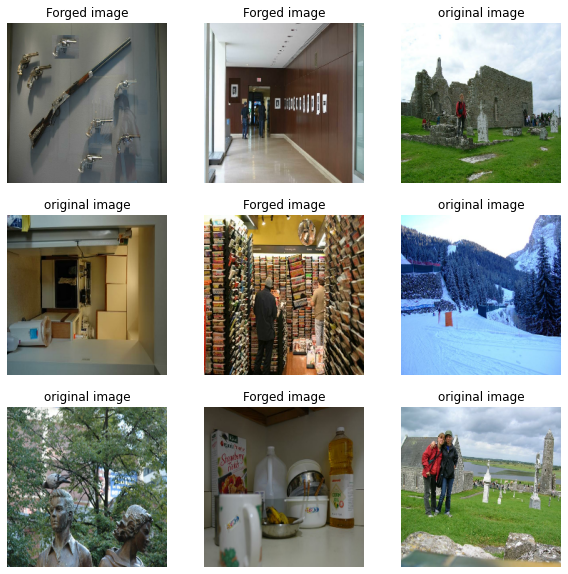

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

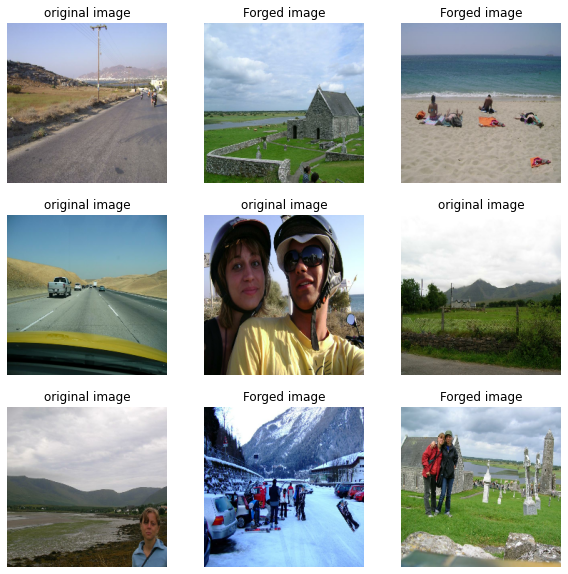

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet")

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(
    inputs, data_format=None)

x = vgg16(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [12]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy (from_logits=False), metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint, EarlyStopping
cb = ModelCheckpoint("Vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)




In [13]:
history = model.fit(train_ds,epochs=15, validation_data=val_ds, callbacks = cb)

Epoch 1/15
2/2 [==============================] - ETA: 0s - loss: 1.1606 - accuracy: 0.5385 
Epoch 1: val_accuracy improved from -inf to 0.58000, saving model to Vgg16_1.h5
2/2 [==============================] - 34s 16s/step - loss: 1.1606 - accuracy: 0.5385 - val_loss: 0.6662 - val_accuracy: 0.5800
Epoch 2/15
2/2 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.7094
Epoch 2: val_accuracy improved from 0.58000 to 0.66000, saving model to Vgg16_1.h5
2/2 [==============================] - 3s 2s/step - loss: 0.5983 - accuracy: 0.7094 - val_loss: 0.5809 - val_accuracy: 0.6600
Epoch 3/15
2/2 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.8034
Epoch 3: val_accuracy improved from 0.66000 to 0.80000, saving model to Vgg16_1.h5
2/2 [==============================] - 3s 2s/step - loss: 0.5473 - accuracy: 0.8034 - val_loss: 0.5409 - val_accuracy: 0.8000
Epoch 4/15
2/2 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8376
Epoch

In [14]:
import numpy as np
import tensorflow as tf

predictions = np.array([])
labels =  np.array([])
i=0;
for x, y in test_ds:
    i+=1
    z=model.predict(x)
    xx = np.round(z)
    prediction=np.concatenate([predictions,xx[:,-1]])
    labels = np.concatenate([labels, y.numpy()])



2/2 [==============================] - 6s 3s/step


In [15]:
evaluation = model.evaluate(test_ds, return_dict=True)

1/1 [==============================] - 5s 5s/step - loss: 1.5449 - accuracy: 0.7258


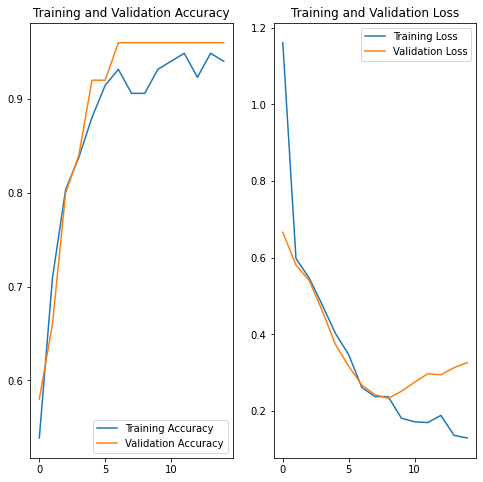

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
labels

array([1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.])

In [19]:
prediction

array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.])

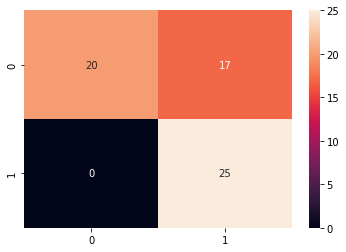

In [20]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(labels,prediction)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [21]:
import sklearn
print(sklearn.metrics.classification_report(prediction,labels))

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70        20
         1.0       1.00      0.60      0.75        42

    accuracy                           0.73        62
   macro avg       0.77      0.80      0.72        62
weighted avg       0.85      0.73      0.73        62

